In [1]:
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d msambare/fer2013
!unzip fer2013.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/sad/Training_65242339.jpg  
  inflating: train/sad/Training_65267116.jpg  
  inflating: train/sad/Training_65275626.jpg  
  inflating: train/sad/Training_6529266.jpg  
  inflating: train/sad/Training_65329617.jpg  
  inflating: train/sad/Training_65338712.jpg  
  inflating: train/sad/Training_65338797.jpg  
  inflating: train/sad/Training_65387162.jpg  
  inflating: train/sad/Training_65404494.jpg  
  inflating: train/sad/Training_65426218.jpg  
  inflating: train/sad/Training_65430136.jpg  
  inflating: train/sad/Training_65437377.jpg  
  inflating: train/sad/Training_6545735.jpg  
  inflating: train/sad/Training_65463385.jpg  
  inflating: train/sad/Training_65473985.jpg  
  inflating: train/sad/Training_65502829.jpg  
  inflating: train/sad/Training_65505359.jpg  
  inflating: train/sad/Training_65508578.jpg  
  inflating: train/sad/Training_65516023.jpg  
  inflating: train/sad/Training_65524027.jpg  
  inflating

In [2]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import transforms, models
from torchvision.datasets import ImageFolder

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 0.001
STEP_SIZE = 5
TRANSFORMS = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485], [0.229])
])

In [5]:
print('[INFO] Loading data...')
train_data = ImageFolder('./train', transform=TRANSFORMS)
val_data = ImageFolder('./test', transform=TRANSFORMS)
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)

[INFO] Loading data...


In [6]:
LABELS = train_data.classes
N_LABELS = len(LABELS)
print(LABELS)

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [7]:
print('[INFO] Loading model...')
model = models.resnet18(pretrained=True)
model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.fc = torch.nn.Linear(model.fc.in_features, N_LABELS)
model = model.to(device)

[INFO] Loading model...


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 54.6MB/s]


In [8]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=0.1)

In [9]:
history = {
    'max_val_accuracy' : 0,
    'train_accuracy' : [],
    'val_accuracy' : [],
    'train_loss' : [],
    'val_loss' : [],
}

In [10]:
print('[INFO] Training model...')
for epoch in range(EPOCHS):
    model.train()

    total_train_loss = 0
    train_correct = 0

    total_val_loss = 0
    val_correct = 0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)

        pred = model(x)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        train_correct += (torch.argmax(pred, 1) == y).sum().item()

    with torch.no_grad():
        model.eval()
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)

            pred = model(x)
            loss = loss_fn(pred, y)

            total_val_loss += loss.item()
            val_correct += (torch.argmax(pred, 1) == y).sum().item()

    scheduler.step()

    avg_train_loss = total_train_loss / len(train_loader)
    avg_val_loss = total_val_loss / len(val_loader)
    train_accuracy = train_correct / len(train_loader.dataset)
    val_accuracy = val_correct / len(val_loader.dataset)

    history['train_accuracy'].append(train_accuracy)
    history['val_accuracy'].append(val_accuracy)
    history['train_loss'].append(avg_train_loss)
    history['val_loss'].append(avg_val_loss)

    if history['max_val_accuracy'] < val_accuracy:
        history['max_val_accuracy'] = val_accuracy
        torch.save(model.state_dict(), 'best_accuracy_model.pth')

    print(f'[INFO] EPOCH: {epoch + 1}/{EPOCHS}')
    print(f'[INFO] Train Accuracy: {train_accuracy:.4f}, Train Loss: {avg_train_loss:.4f}')
    print(f'[INFO] Val Accuracy: {val_accuracy:.4f}, Val Loss: {avg_val_loss:.4f}\n')

[INFO] Training model...
[INFO] EPOCH: 1/20
[INFO] Train Accuracy: 0.5074, Train Loss: 1.2971
[INFO] Val Accuracy: 0.5469, Val Loss: 1.2209

[INFO] EPOCH: 2/20
[INFO] Train Accuracy: 0.5924, Train Loss: 1.0860
[INFO] Val Accuracy: 0.5854, Val Loss: 1.1055

[INFO] EPOCH: 3/20
[INFO] Train Accuracy: 0.6358, Train Loss: 0.9736
[INFO] Val Accuracy: 0.6115, Val Loss: 1.0398

[INFO] EPOCH: 4/20
[INFO] Train Accuracy: 0.6839, Train Loss: 0.8642
[INFO] Val Accuracy: 0.6213, Val Loss: 1.0297

[INFO] EPOCH: 5/20
[INFO] Train Accuracy: 0.7289, Train Loss: 0.7272
[INFO] Val Accuracy: 0.6417, Val Loss: 1.0049

[INFO] EPOCH: 6/20
[INFO] Train Accuracy: 0.8785, Train Loss: 0.3511
[INFO] Val Accuracy: 0.6597, Val Loss: 1.1843

[INFO] EPOCH: 7/20
[INFO] Train Accuracy: 0.9393, Train Loss: 0.1833
[INFO] Val Accuracy: 0.6513, Val Loss: 1.4232

[INFO] EPOCH: 8/20
[INFO] Train Accuracy: 0.9748, Train Loss: 0.0878
[INFO] Val Accuracy: 0.6528, Val Loss: 1.6095

[INFO] EPOCH: 9/20
[INFO] Train Accuracy: 0.989

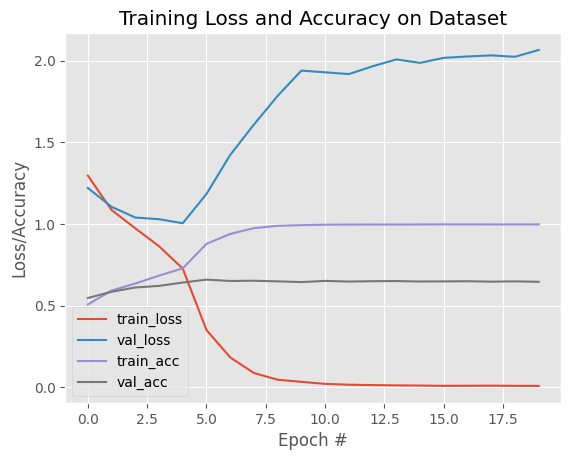

In [11]:
plt.style.use("ggplot")
plt.figure()
plt.plot(history["train_loss"], label="train_loss")
plt.plot(history["val_loss"], label="val_loss")
plt.plot(history["train_accuracy"], label="train_acc")
plt.plot(history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

In [12]:
torch.save(model.state_dict(), 'emotion_recognition_model_resent18.pth')